In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../source')
sys.path.insert(0, '../scripts')

In [2]:
import metavars
metavars.lake_name = 'synth'        # set to 'synth' or one of the lakes in the inventory
lake_name = metavars.lake_name
from make_synth_data import make_data

In [3]:
H = 2000
lamda = 0.5
gamma = 1
eta = 0.5*(917*9.81*H)*3.154e7/(lamda) 
beta = 2*eta*gamma/H

t_cycle = 5
dir_name = '../results/results_synth_lamda_'+'{:.1f}'.format(lamda)
!rm -r {dir_name};
!mkdir {dir_name}
make_data(t_cycle,beta,eta,H)

Print the auxiliary parameters (ice thickness, basal drag, viscosity, velocities):

In [4]:
# print the auxiliary model parameters
from print_params import print_params
print_params()

auxiliary model parameters:
H = 2000 m
beta = 5.7e+11 Pa s m^-1
eta = 5.7e+14 Pa s
u = 0.0 m yr^-1
v = 0.0 m yr^-1
relaxation time = 2.0 yr


nondimensonal parameters:
lambda = 0.5000
gamma = 1.0000


Calculate the effective pressure!

In [5]:
from kernel_fcns import fftd,ifftd,C_h,C_w
from params import data_dir,lamda0,delta,N_sc,x0,y0,t0,k
from post_process import calc_s
# load elevation data (h_obs)

xp,yp = np.meshgrid(x0,y0)
rad = 5
bdry = 1+0*xp
bdry[np.sqrt((xp)**2+(yp)**2)>rad] = 0


h = np.load(data_dir+'/h_true.npy')
w = np.load(data_dir+'/w_true.npy')
s = calc_s(w,initial=0)

s_mean = np.zeros(s.shape[0])
for i in range(s.shape[0]):
    s_i = s[i,:,:]
    s_mean[i] = s_i[bdry.T>1e-2].mean()

h_ft = fftd(h)
w_ft = fftd(w)
N_ft = (1/lamda0)*C_w()*w_ft - C_h()*h_ft 
N = ifftd(N_ft).real + delta*(s.T -s_mean.T).T * bdry


In [6]:
def get_means(N,w,h,bdry):
    N_mean = np.zeros(N.shape[0])
    w_mean = np.zeros(w.shape[0])
    h_mean = np.zeros(h.shape[0])

    for i in range(N.shape[0]):
        N_i = N[i,:,:]
        w_i = w[i,:,:]
        h_i = h[i,:,:]

        N_mean[i] = N_i[bdry>1e-2].mean()
        w_mean[i] = w_i[bdry>1e-2].mean()
        h_mean[i] = h_i[bdry>1e-2].mean()
    return N_mean, w_mean, h_mean   

N_mean, w_mean, h_mean   = get_means(N,w,h,bdry)

In [7]:
np.save(dir_name+'/N.npy',N)
np.save(dir_name+'/w.npy',w)
np.save(dir_name+'/h.npy',h)
np.save(dir_name+'/h_mean.npy',h_mean)
np.save(dir_name+'/N_mean.npy',N_mean)
np.save(dir_name+'/w_mean.npy',w_mean)
np.save(dir_name+'/x.npy',x0)
np.save(dir_name+'/y.npy',y0)
np.save(dir_name+'/t.npy',t0)
np.save(dir_name+'/bdry.npy',bdry)


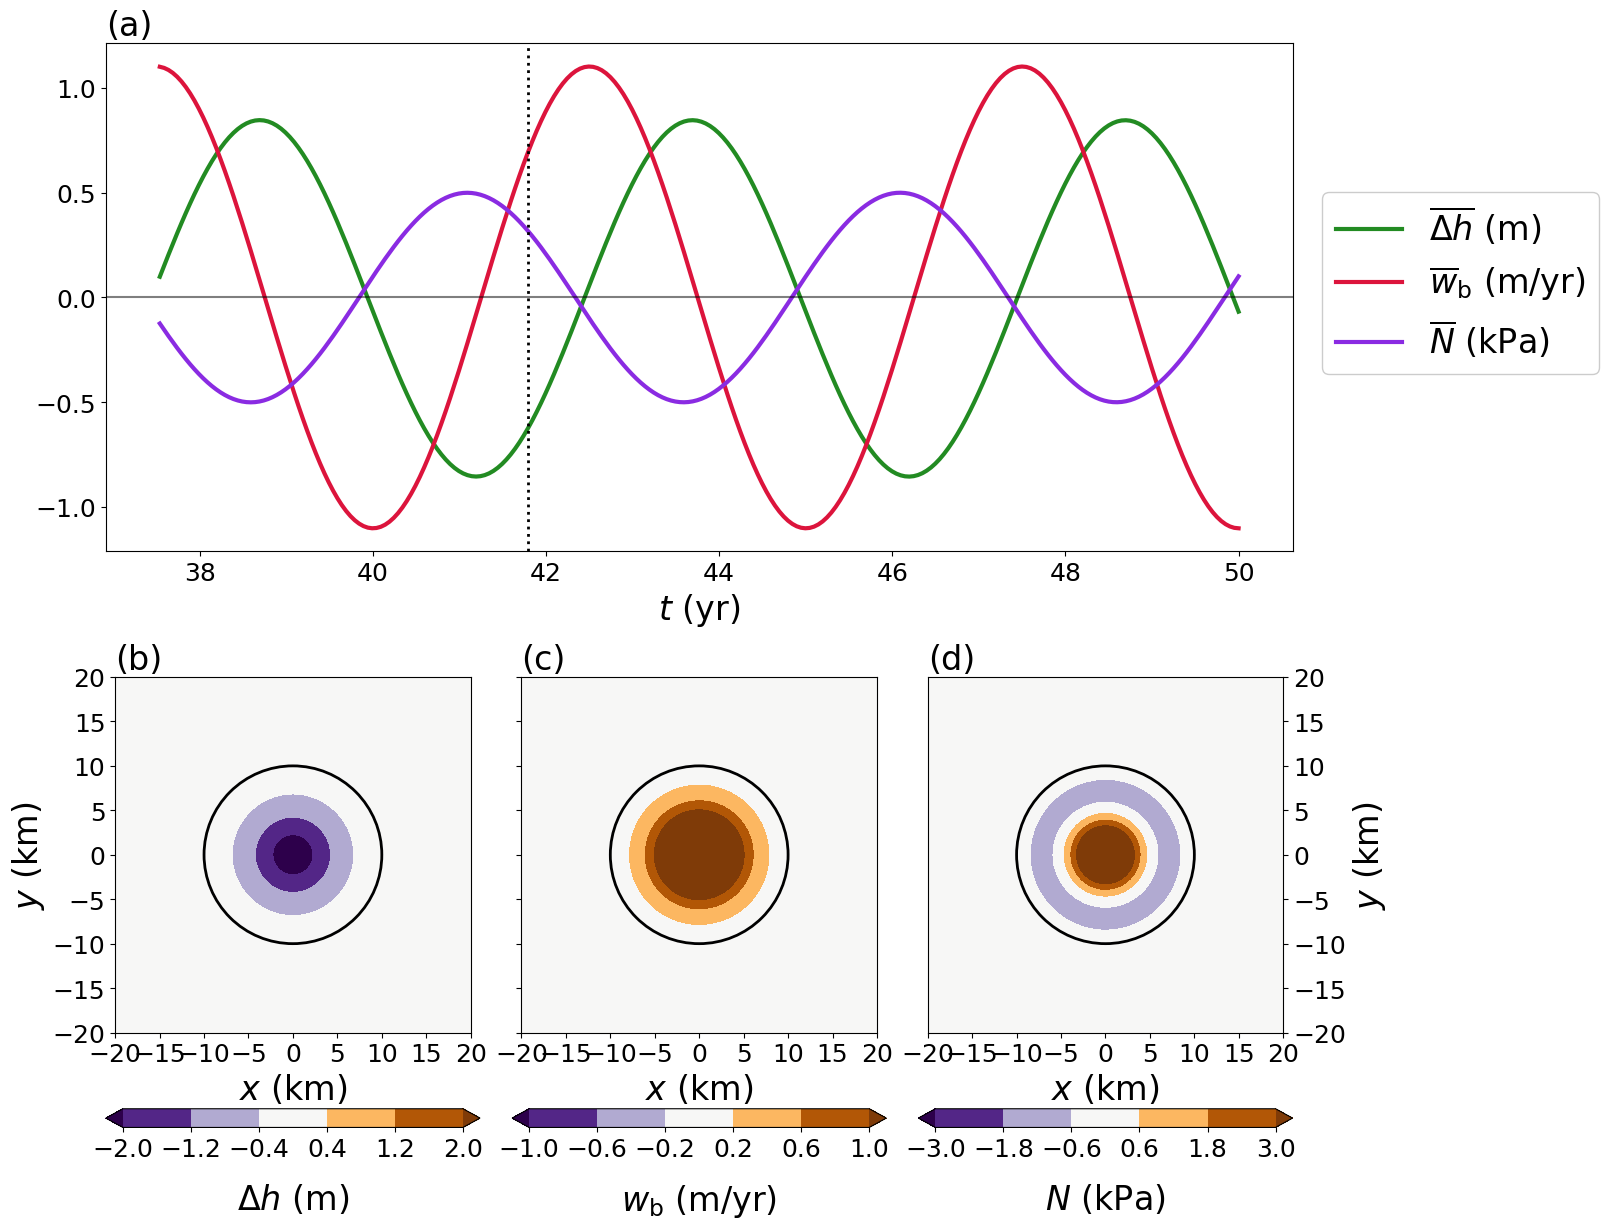

In [8]:
xp,yp = np.meshgrid(x0*H/1e3,y0*H/1e3)

l = 835
j0 = int(0.75*t0.size)
plt.figure(figsize=(16,12.5))

plt.subplot(211)
plt.title('(a)',loc='left',fontsize=24)
plt.plot(t0[j0:None],h_mean[j0:None],color='forestgreen',linewidth=3,label=r'$\overline{\Delta h}$ (m)')
plt.plot(t0[j0:None],w_mean[j0:None],color='crimson',linewidth=3,label=r'$\overline{w}_\mathrm{b}$ (m/yr)')
plt.plot(t0[j0:None],N_mean[j0:None]*N_sc/1e3,color='blueviolet',linewidth=3,label=r'$\overline{N}$ (kPa)')
plt.axvline(x=t0[l],color='k',linestyle=':',linewidth=2)
plt.axhline(y=0,color='k',linestyle='-',alpha=0.5)
plt.xlabel(r'$t$ (yr)',fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=24,loc=(1.025,0.35),framealpha=1)

plt.subplot(234)
plt.title('(b)',loc='left',fontsize=24)
p = plt.contourf(xp,yp,h[l,:,:],cmap='PuOr_r',levels=np.linspace(-2,2,6),extend='both')
# p = plt.contourf(xp,yp,bdry*((s.T -s_mean.T).T)[l,:,:],cmap='PuOr_r',levels=np.linspace(-2,2,6),extend='both')
circle = plt.Circle((0, 0), rad*H/1e3, color='k',fill=False,linewidth=2)
plt.gca().add_patch(circle)
cbar = plt.colorbar(p,orientation='horizontal')
cbar.set_label(r'$\Delta h$ (m)',fontsize=24,labelpad=15)
cbar.ax.tick_params(labelsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r'$x$ (km)',fontsize=24)
plt.ylabel(r'$y$ (km)',fontsize=24)
plt.gca().set_aspect('equal', 'box')


plt.subplot(235)
plt.title('(c)',loc='left',fontsize=24)
p = plt.contourf(xp,yp,w[l,:,:],cmap='PuOr_r',levels=np.linspace(-1,1,6),extend='both')
circle = plt.Circle((0, 0), rad*H/1e3, color='k',fill=False,linewidth=2)
plt.gca().add_patch(circle)
cbar = plt.colorbar(p,orientation='horizontal')
cbar.set_label(r'$w_\mathrm{b}$ (m/yr)',fontsize=24,labelpad=15)
cbar.ax.tick_params(labelsize=18)
plt.xticks(fontsize=18)
plt.xlabel(r'$x$ (km)',fontsize=24)
plt.gca().yaxis.set_ticklabels([])
plt.gca().set_aspect('equal', 'box')

plt.subplot(236)
plt.title('(d)',loc='left',fontsize=24)
p = plt.contourf(xp,yp,N[l,:,:]*N_sc/1e3,cmap='PuOr_r',levels=np.linspace(-3,3,6),extend='both')
circle = plt.Circle((0, 0), rad*H/1e3, color='k',fill=False,linewidth=2)
plt.gca().add_patch(circle)
plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r'$x$ (km)',fontsize=24)
plt.ylabel(r'$y$ (km)',fontsize=24)
plt.gca().set_aspect('equal', 'box')

cbar = plt.colorbar(p,orientation='horizontal')
cbar.set_label(r'$N$ (kPa)',fontsize=24,labelpad=15)
cbar.ax.tick_params(labelsize=18)
plt.tight_layout()
plt.savefig('fig5')
plt.show()
plt.close()

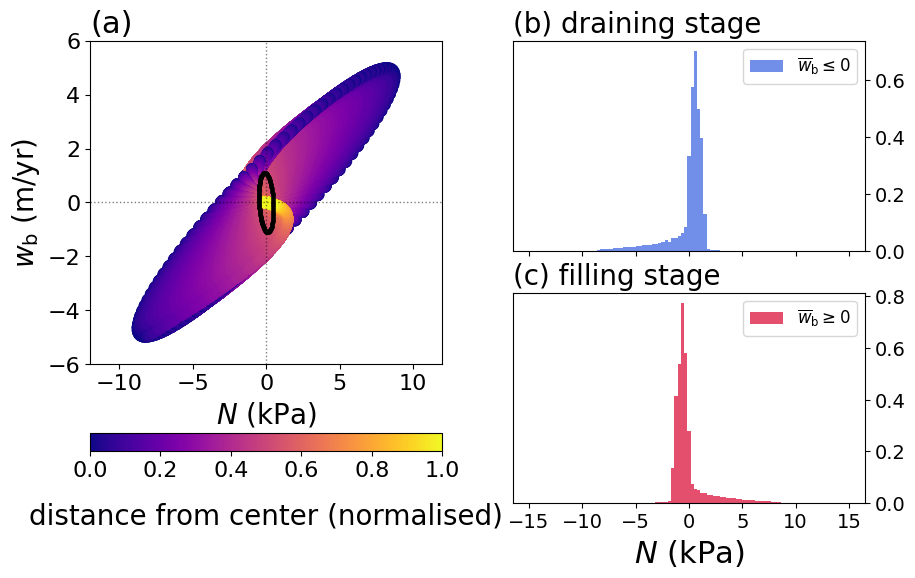

In [9]:
bins = np.linspace(-15,15,100)
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.title(r'(a)',fontsize=22,loc='left')
dir_name = '../results/results_synth_lamda_0.5'
N = np.load(dir_name+'/N.npy')
w = np.load(dir_name+'/w.npy')
N_mean = np.load(dir_name+'/N_mean.npy')
w_mean = np.load(dir_name+'/w_mean.npy')
bdry = np.load(dir_name+'/bdry.npy')
plt.axhline(y=0,linestyle=':',color='k',linewidth=1,alpha=0.5)
plt.axvline(x=0,linestyle=':',color='k',linewidth=1,alpha=0.5)
for i in np.arange(j0,t0.size,1):
    d = (np.sqrt(xp[:,:]**2 + yp[:,:]**2)[bdry>1e-2]).flatten()
    d = d/np.max(d)
    # plt.plot(N[i,:,:][bdry>1e-2].flatten()*N_sc/1e3,w[i,:,:][bdry>1e-2].flatten(),'o',color='royalblue',markersize=1,alpha=0.1)
    sc = plt.scatter(N[i,:,:][bdry>1e-2].flatten()*N_sc/1e3,w[i,:,:][bdry>1e-2].flatten(),s=50,cmap='plasma',c=d)
plt.plot(N_mean[j0:None].flatten()*N_sc/1e3,w_mean[j0:None].flatten(),'o',color='k',markersize=2,alpha=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel(r'$N$ (kPa)',fontsize=20)
plt.ylabel(r'$w_\mathrm{b}$ (m/yr)',fontsize=20)
plt.ylim(-6,6)
plt.xlim(-12,12)
# cbaxes = fig.add_axes([0.1, 0.1, 0.3, 0.05])
cbar = plt.colorbar(sc,orientation='horizontal')#,cax = cbaxes)
cbar.set_label(r'distance from center (normalised)',fontsize=20,labelpad=15)
cbar.ax.tick_params(labelsize=16)
#-----
dir_name = '../results/results_synth_lamda_0.5'
N = np.load(dir_name+'/N.npy')
w = np.load(dir_name+'/w.npy')
bdry = np.load(dir_name+'/bdry.npy')
N_data_p = np.array([])
N_data_m = np.array([])
for i in np.arange(j0,t0.size,1):
    if np.mean(w[i,:,:])>=0:
        N_data_p = np.append(N_data_p,N[i,:,:][bdry>1e-2].flatten()*N_sc/1e3)
    elif np.mean(w[i,:,:])<=0:
        N_data_m = np.append(N_data_m,N[i,:,:][bdry>1e-2].flatten()*N_sc/1e3)
plt.subplot(222)
plt.title(r'(b) draining stage',loc='left',fontsize=20)
plt.hist(N_data_m,bins=bins,density=True,color='royalblue',alpha=0.75,label=r'$\overline{w}_\mathrm{b}\leq 0$')
plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()
plt.gca().xaxis.set_ticklabels([])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.subplot(224)
plt.title(r'(c) filling stage',loc='left',fontsize=20)
plt.hist(N_data_p,bins=bins,density=True,color='crimson',alpha=0.75,label=r'$\overline{w}_\mathrm{b}\geq 0$')
plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$N$ (kPa)',fontsize=22)
plt.legend(fontsize=12)
plt.savefig('fig6',bbox_inches='tight')
plt.show()
plt.close()